In [9]:
import numpy as np
import matplotlib.pyplot as plt
import datasets
from datasets.tabular import TabularModelPerturb
import torch
from train import get_model_class
from util import convert_to_tensor
from similarity_metrics import get_top_k, average_pairwise_score, top_k_sa, top_k_cdc, top_k_consistency
from tqdm import tqdm
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
random_sources = ['rs', 'loo']

In [24]:
name = 'heloc'  # or 'german'
n_models = 100  # 1000 for german if needed
trainset, testset = datasets.load_dataset(name)

X_test, y_test = testset.data.numpy(), testset.labels.numpy()
n_inputs, n_features = X_test.shape

# Weight Perturbations
n_weight_perturbations = 50
sigma = 0.5
layer_str = 'network.0.weight'

# Smoothgrad
sg_samples = 100
sg_sigma = 0.5

# Construct noise for Smoothgrad
noise = np.random.normal(scale=sg_sigma, size=(sg_samples, n_inputs, n_features))
noisy_x = np.vstack([np.expand_dims(X_test, axis=0)] * sg_samples) + noise

model_args = [n_features, datasets.tabular.layers[name]]
model_class = get_model_class(name)
directory = f'models/{name}'
directory

'models/heloc'

In [25]:
def get_sg(model, noisy_x):
    sg = np.zeros_like(noisy_x)
    for i in range(sg.shape[0]):
        sg[i] = model.compute_gradients(noisy_x[i], softmax=False, label=1, return_numpy=True)
    return sg.mean(axis=0)

def load_model(idx, sigma=None, seed=0):
    model = model_class(*model_args)
    state_dict = torch.load(f'{directory}/{random_source}_model_{idx}.pth')
    if sigma is not None:
        torch.manual_seed(seed)
        state_dict[layer_str] += torch.randn(state_dict[layer_str].shape) * sigma
    model.load_state_dict(state_dict)
    return model

### Compute and save predictions from models

In [26]:
logit = model.forward(torch.FloatTensor(X_test)).detach().numpy()
logit.shape

(1975, 2)

In [23]:
for random_source in random_sources[:1]:
    for i in range(n_models):
        model = load_model(i)
        pred = model.predict(X_test)
        logit = model.forward(torch.FloatTensor(X_test)).detach().numpy()
        np.save(f'{directory}/{random_source}_preds_{i}.npy', pred)
        np.save(f'{directory}/{random_source}_logits_{i}.npy', logit)

### Compute and save predictions from perturbed models

In [27]:
model_class = get_model_class(name)
for random_source in random_sources[:1]:
    for i in tqdm(range(n_models)):
        model = load_model(i)
        pert_model = TabularModelPerturb(model, n_weight_perturbations, sigma)
        logit = pert_model.forward(torch.FloatTensor(X_test)).detach().numpy().mean(axis=0)
        pred = np.argmax(logit, axis=1)
        grad = pert_model.compute_gradients(X_test, mean=True)
        np.save(f'{directory}/{random_source}_preds_smooth_{i}.npy', pred)
        np.save(f'{directory}/{random_source}_logits_smooth_{i}.npy', logit)
        np.save(f'{directory}/{random_source}_grads_smooth_{i}.npy', grad)

100%|██████████| 100/100 [00:11<00:00,  8.55it/s]


### Compute and save gradients from models

In [199]:
for random_source in random_sources[:1]:
    for i in tqdm(range(n_models)):
        model = load_model(i)
        # Compute positive class softmax prediction gradient wrt input (softmax=False for logit output)
        grads = model.compute_gradients(X_test, softmax=False, label=1, return_numpy=True)
        np.save(f'{directory}/{random_source}_grads_{i}.npy', grads)

        # Compute Smoothgrad
        sg = get_sg(model, noisy_x)
        np.save(f'{directory}/{random_source}_sg_{i}.npy', sg)

100%|██████████| 100/100 [00:11<00:00,  8.66it/s]


### Compute and save gradients from perturbed models

In [200]:
model_class = get_model_class(name)
for random_source in random_sources[:1]:
    for i in tqdm(range(n_models)):
        grads_smooth = np.zeros((n_inputs, n_features))
        #sg_smooth = np.zeros((n_inputs, n_features))
        for j in range(n_weight_perturbations):
            # Add noise to layer weights
            model = load_model(i, sigma=sigma, seed=j)
            # Compute new gradients
            grads_smooth += model.compute_gradients(X_test, softmax=False, label=1, return_numpy=True)
            #sg_smooth += get_sg(model, noisy_x)
        grads_smooth /= n_weight_perturbations
        #sg_smooth /= n_weight_perturbations
        np.save(f'{directory}/{random_source}_grads_smooth_{i}.npy', grads_smooth)
        #np.save(f'{directory}/{random_source}_sg_smooth_{i}.npy', sg_smooth)

100%|██████████| 100/100 [00:18<00:00,  5.37it/s]


### Path to Glory

In [201]:
# Ensemble sizes
ensemble_sizes = [2, 3, 4, 5, 10]

# Test point indices
test_idx = range(X_test.shape[0])
x = X_test[test_idx]

# Random source
random_source = random_sources[0]

# Number of ensembles to sample for each ensemble size
n_trials = 10

# Top-k features to consider
k = 5

# Store no. inputs and no. features
n_inputs, n_features = X_test.shape

In [206]:
for e, ensemble_size in tqdm(enumerate(ensemble_sizes)):
    for i in range(n_trials):
        print(list(range(i*ensemble_size, (i+1)*ensemble_size)))

5it [00:00, 8665.92it/s]

[0, 1]
[2, 3]
[4, 5]
[6, 7]
[8, 9]
[10, 11]
[12, 13]
[14, 15]
[16, 17]
[18, 19]
[0, 1, 2]
[3, 4, 5]
[6, 7, 8]
[9, 10, 11]
[12, 13, 14]
[15, 16, 17]
[18, 19, 20]
[21, 22, 23]
[24, 25, 26]
[27, 28, 29]
[0, 1, 2, 3]
[4, 5, 6, 7]
[8, 9, 10, 11]
[12, 13, 14, 15]
[16, 17, 18, 19]
[20, 21, 22, 23]
[24, 25, 26, 27]
[28, 29, 30, 31]
[32, 33, 34, 35]
[36, 37, 38, 39]
[0, 1, 2, 3, 4]
[5, 6, 7, 8, 9]
[10, 11, 12, 13, 14]
[15, 16, 17, 18, 19]
[20, 21, 22, 23, 24]
[25, 26, 27, 28, 29]
[30, 31, 32, 33, 34]
[35, 36, 37, 38, 39]
[40, 41, 42, 43, 44]
[45, 46, 47, 48, 49]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
[40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
[50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
[60, 61, 62, 63, 64, 65, 66, 67, 68, 69]
[70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
[80, 81, 82, 83, 84, 85, 86, 87, 88, 89]
[90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


In [202]:
# Count variables
topk, signs, counts = [], [], []
counts_pos, counts_neg = [], []
topk_counts_signed, signs_counts_signed = [], []

# 'Average ensemble' variables (take mean of gradients across models)
topk_avg = np.zeros((len(ensemble_sizes), n_trials, len(test_idx), k))
signs_avg = np.zeros((len(ensemble_sizes), n_trials, len(test_idx), k), dtype=int)

# 'Norm-average ensemble' variables (normalize gradients to unit l2-norm for each model, then take mean)
topk_norm_avg = np.zeros((len(ensemble_sizes), n_trials, len(test_idx), k))
signs_norm_avg = np.zeros((len(ensemble_sizes), n_trials, len(test_idx), k), dtype=int)

# 'Average smooth ensemble' variables (for each model, add noise to weights and recompute gradients, take mean)
topk_smooth = np.zeros((len(ensemble_sizes), n_trials, len(test_idx), k))
signs_smooth = np.zeros((len(ensemble_sizes), n_trials, len(test_idx), k), dtype=int)

# Smoothgrad
topk_sg = np.zeros((len(ensemble_sizes), n_trials, len(test_idx), k))
signs_sg = np.zeros((len(ensemble_sizes), n_trials, len(test_idx), k), dtype=int)

# Smooth Smoothgrad
topk_sg_smooth = np.zeros((len(ensemble_sizes), n_trials, len(test_idx), k))
signs_sg_smooth = np.zeros((len(ensemble_sizes), n_trials, len(test_idx), k), dtype=int)

# Test accuracies
test_accs = np.zeros((len(ensemble_sizes), n_trials))
test_accs_smooth = np.zeros((len(ensemble_sizes), n_trials))

for e, ensemble_size in tqdm(enumerate(ensemble_sizes)):
    tk = np.zeros((n_trials, ensemble_size, len(test_idx), k))
    s = np.zeros((n_trials, ensemble_size, len(test_idx), k), dtype=int)
    co = np.zeros((n_trials, len(test_idx), n_features))
    
    # Initialize count arrays
    co_pos = np.zeros((n_trials, len(test_idx), n_features))
    co_neg = np.zeros((n_trials, len(test_idx), n_features))

    for i in range(n_trials):
        # Models, gradients, and predictions
        model_idx = range(i*ensemble_size, (i+1)*ensemble_size) #np.random.choice(n_models, ensemble_size, replace=False)
        grads = np.array([np.load(f'{directory}/{random_source}_grads_{idx}.npy') for idx in model_idx])
        grads = grads[:, test_idx]
        preds = np.array([np.load(f'{directory}/{random_source}_preds_{idx}.npy') for idx in model_idx])
        preds = preds[:, test_idx].mean(axis=0)
        avg_preds = np.zeros_like(preds)
        avg_preds[preds >= 0.5] = 1
        preds_smooth = np.array([np.load(f'{directory}/{random_source}_preds_smooth_{idx}.npy') for idx in model_idx])
        preds_smooth = preds_smooth[:, test_idx].mean(axis=0)
        avg_preds_smooth = np.zeros_like(preds_smooth)
        avg_preds_smooth[preds_smooth >= 0.5] = 1

        # Test accuracies
        test_accs[e, i] = (avg_preds == y_test[test_idx]).mean()
        test_accs_smooth[e, i] = (avg_preds_smooth == y_test[test_idx]).mean()

        tk[i], s[i] = get_top_k(k=k, X=grads, return_sign=True)
        topk_avg[e, i], signs_avg[e, i] = get_top_k(k=k, X=grads.mean(axis=0), return_sign=True)
        norm_grads = grads/np.linalg.norm(grads+1e-20, axis=2, keepdims=True)
        topk_norm_avg[e, i], signs_norm_avg[e, i] =\
            get_top_k(k=k, X=norm_grads.mean(axis=0), return_sign=True)

        # Grads smooth
        grads_smooth = np.array([np.load(f'{directory}/{random_source}_grads_smooth_{idx}.npy') for idx in model_idx])
        grads_smooth = grads_smooth[:, test_idx]
        topk_smooth[e, i], signs_smooth[e, i] = get_top_k(k=k, X=grads_smooth.mean(axis=0), return_sign=True)

        # Smoothgrad
        sg = np.array([np.load(f'{directory}/{random_source}_sg_{idx}.npy') for idx in model_idx])
        sg = sg[:, test_idx]
        topk_sg[e, i], signs_sg[e, i] = get_top_k(k=k, X=sg.mean(axis=0), return_sign=True)

        # # Smoothgrad smooth
        # sg_smooth = np.array([np.load(f'{directory}/{random_source}_sg_smooth_{idx}.npy') for idx in model_idx])
        # sg_smooth = sg_smooth[:, test_idx]
        # topk_sg_smooth[e, i], signs_sg_smooth[e, i] = get_top_k(k=k, X=sg_smooth.mean(axis=0), return_sign=True)

        
        # # Smooth ensemble
        # smooth_grads = np.zeros_like(grads)
        # smooth_sg = np.zeros_like(grads)
        # sg = np.zeros_like(grads)
        # for j in range(ensemble_size):
        #     model = load_model(model_idx[j])
        #     sg[j] = get_sg(model, noisy_x)
        #     for _ in range(n_weight_perturbations):
        #         # Add noise to layer weights
        #         model = load_model(model_idx[j], sigma=sigma)

        #         # Compute new gradients
        #         smooth_grads[j] += model.compute_gradients(x, softmax=False, label=1, return_numpy=True)
        #         smooth_sg[j] += get_sg(model, noisy_x)
        # smooth_grads /= n_weight_perturbations
        # smooth_sg /= n_weight_perturbations

        # topk_smooth[e, i], signs_smooth[e, i] =\
        #     get_top_k(k=k, X=smooth_grads.mean(axis=0), return_sign=True)
        # topk_smooth_sg[e, i], signs_smooth_sg[e, i] =\
        #     get_top_k(k=k, X=smooth_sg.mean(axis=0), return_sign=True)
        # topk_sg[e, i], signs_sg[e, i] =\
        #     get_top_k(k=k, X=sg.mean(axis=0), return_sign=True)


        # Compute counts
        for t_i in range(len(test_idx)):
            # Unique indices and their counts
            u, c = np.unique(tk[i, :, t_i].flatten(), return_counts=True)
            co[i, t_i, u.astype(int)] = c
            for j in range(ensemble_size):
                for l in range(k):
                    feature_idx = tk[i, j, t_i, l].astype(int)
                    feature_sign = s[i, j, t_i, l]

                    if feature_sign > 0:
                        co_pos[i, t_i, feature_idx] += 1
                    elif feature_sign < 0:
                        co_neg[i, t_i, feature_idx] += 1
    tk_co_s, s_co_s = get_top_k(k, co_pos-co_neg, return_sign=True)
    
    # Append to lists
    topk.append(tk)
    signs.append(s)
    counts.append(co)
    counts_pos.append(co_pos)
    counts_neg.append(co_neg)
    topk_counts_signed.append(tk_co_s)
    signs_counts_signed.append(s_co_s)

5it [00:04,  1.22it/s]


### Plot Metrics (need to adjust similarity_metrics.py to suit our uses)

In [203]:
# Count-based
SA = np.zeros((len(ensemble_sizes), len(test_idx)))
#consistencies = np.zeros((len(counts), len(test_idx)))
#CDC = np.zeros((len(counts), len(test_idx)))
#SSA = np.zeros((len(counts), len(test_idx)))

# Average/norm-average/smooth ensemble
SA_avg = np.zeros((len(ensemble_sizes), len(test_idx)))
SA_norm_avg = np.zeros((len(ensemble_sizes), len(test_idx)))
SA_smooth = np.zeros((len(ensemble_sizes), len(test_idx)))
SA_sg = np.zeros((len(ensemble_sizes), len(test_idx)))
# SA_sg_smooth = np.zeros((len(ensemble_sizes), len(test_idx)))

for i in tqdm(range(len(ensemble_sizes))):
    # Counting-based feature attributions
    tk_count = topk_counts_signed[i]
    sign_count = signs_counts_signed[i]
    #consistencies[i] = top_k_consistency(tk_count)
    #CDC[i] = average_pairwise_score(tk_count, sign_count, top_k_cdc)

    # Compute Signed-Agreement
    SA[i] = average_pairwise_score(tk_count, sign_count, top_k_sa)
    SA_avg[i] = average_pairwise_score(topk_avg[i], signs_avg[i], top_k_sa)
    SA_norm_avg[i] = average_pairwise_score(topk_norm_avg[i], signs_norm_avg[i], top_k_sa)
    SA_smooth[i] = average_pairwise_score(topk_smooth[i], signs_smooth[i], top_k_sa)
    SA_sg[i] = average_pairwise_score(topk_sg[i], signs_sg[i], top_k_sa)
    # SA_sg_smooth[i] = average_pairwise_score(topk_sg_smooth[i], signs_sg_smooth[i], top_k_sa)

100%|██████████| 5/5 [00:16<00:00,  3.27s/it]


In [130]:
from similarity_metrics import average_ground_truth_score

# GROUND TRUTH
grads = np.array([np.load(f'{directory}/{random_source}_grads_{idx}.npy') for idx in model_idx])
gt, signs_gt = get_top_k(k, grads.mean(axis=0), return_sign=True)
sg = np.array([np.load(f'{directory}/{random_source}_sg_{idx}.npy') for idx in model_idx])
gt_sg, signs_gt_sg = get_top_k(k, sg.mean(axis=0), return_sign=True)

# Similarities
SA = np.zeros((len(ensemble_sizes), len(test_idx)))
SA_avg = np.zeros((len(ensemble_sizes), len(test_idx)))
SA_norm_avg = np.zeros((len(ensemble_sizes), len(test_idx)))
SA_smooth = np.zeros((len(ensemble_sizes), len(test_idx)))
SA_sg = np.zeros((len(ensemble_sizes), len(test_idx)))
SA_sg_smooth = np.zeros((len(ensemble_sizes), len(test_idx)))

for i in tqdm(range(len(ensemble_sizes))):
    # Counting-based feature attributions
    tk_count = topk_counts_signed[i]
    sign_count = signs_counts_signed[i]

    # Compute Signed-Agreement
    SA[i] = average_ground_truth_score(tk_count, sign_count, gt, signs_gt, top_k_sa)
    SA_avg[i] = average_ground_truth_score(topk_avg[i], signs_avg[i], gt, signs_gt, top_k_sa)
    SA_norm_avg[i] = average_ground_truth_score(topk_norm_avg[i], signs_norm_avg[i], gt, signs_gt, top_k_sa)
    SA_smooth[i] = average_ground_truth_score(topk_smooth[i], signs_smooth[i], gt, signs_gt, top_k_sa)
    SA_sg[i] = average_ground_truth_score(topk_sg[i], signs_sg[i], gt_sg, signs_gt_sg, top_k_sa)
    SA_sg_smooth[i] = average_ground_truth_score(topk_sg_smooth[i], signs_sg_smooth[i], gt_sg, signs_gt_sg, top_k_sa)

100%|██████████| 11/11 [00:09<00:00,  1.15it/s]


In [45]:
%store -r SA_mod2
%store -r SA_sg_mod2

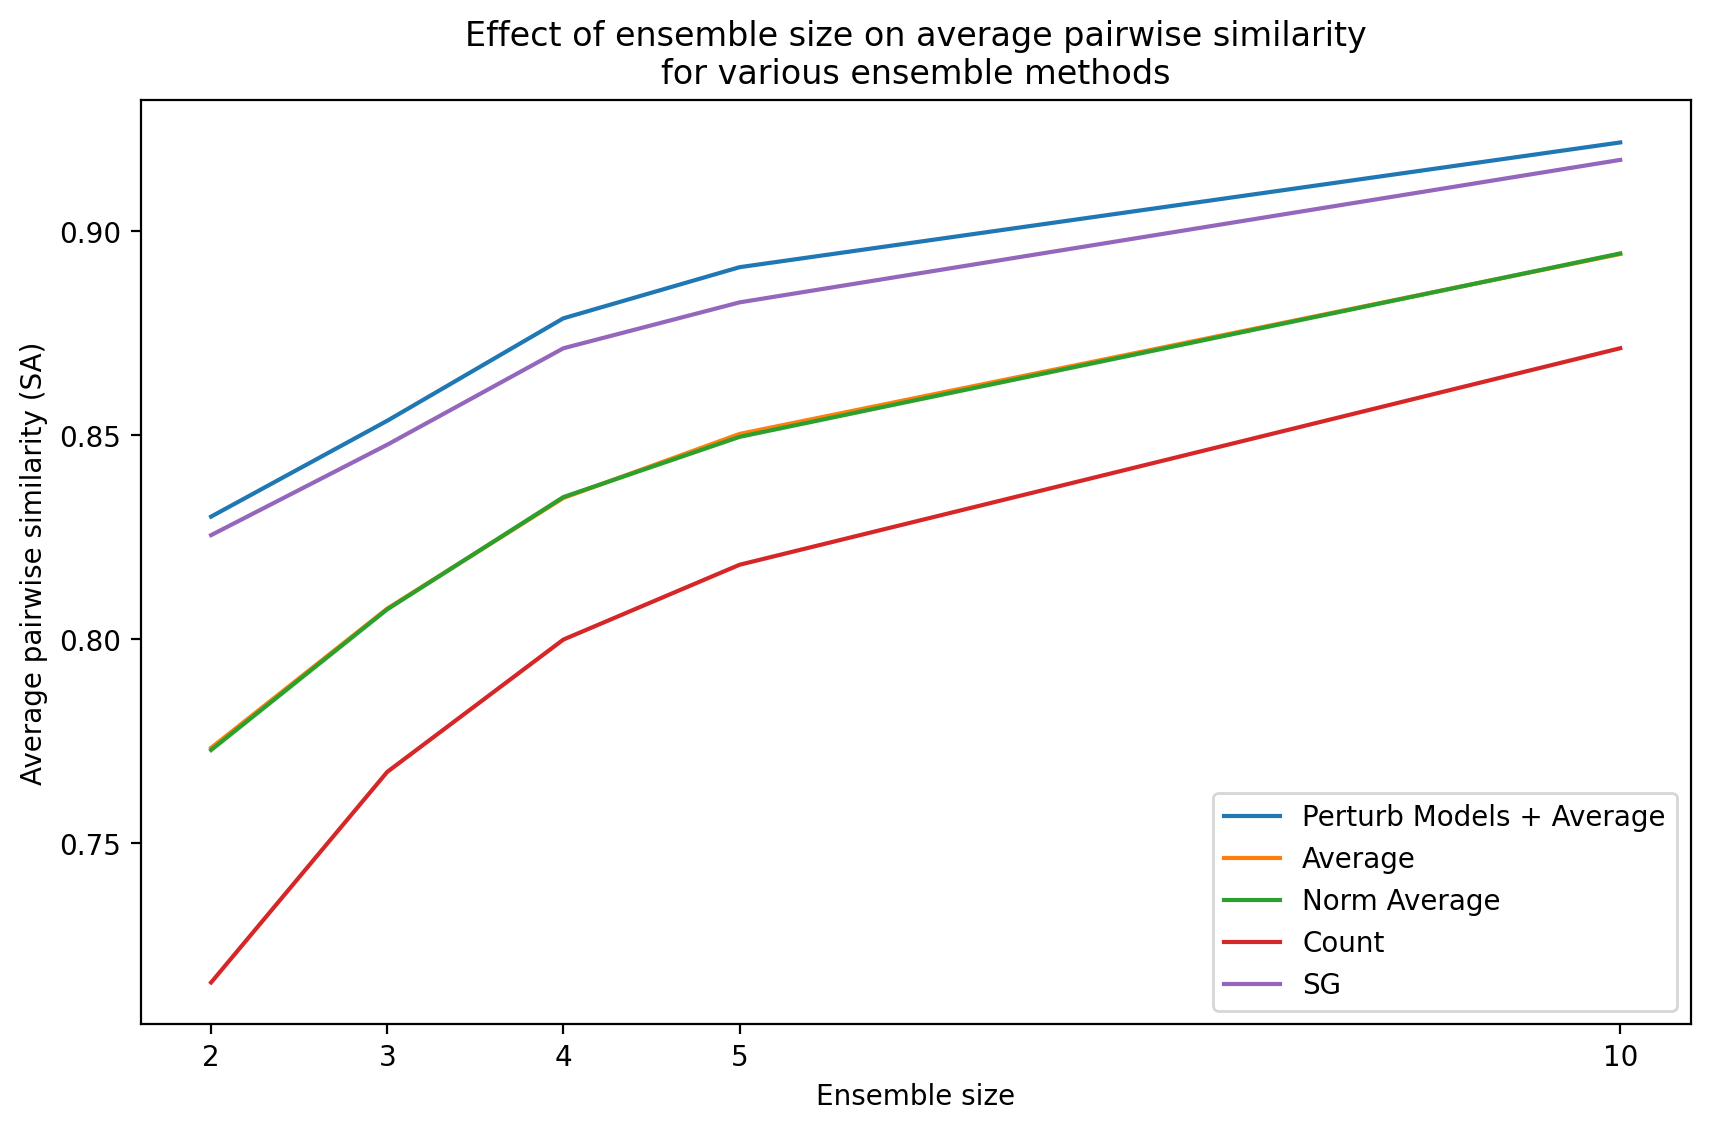

In [205]:
plt.figure(figsize=(10, 6), dpi=200)
titles = ['Perturb Models + Average', 'Average', 'Norm Average', 'Count', 'SG']
for i, metric in enumerate([SA_smooth, SA_avg, SA_norm_avg, SA, SA_sg]):
    # Error bars represent different inputs
    q = np.quantile(metric, [0.4, 0.5, 0.6], axis=1)
    plt.plot(ensemble_sizes, metric.mean(axis=1), label=titles[i])  # plot 50% quantile
    #plt.fill_between(ensemble_sizes, q[0], q[2], alpha=0.2)  # fill between 25% and 75% quantiles
plt.xlabel('Ensemble size')
plt.xticks(ensemble_sizes)
plt.ylabel('Average pairwise similarity (SA)')
plt.title('Effect of ensemble size on average pairwise similarity\nfor various ensemble methods')
plt.legend(loc='lower right')
plt.show()

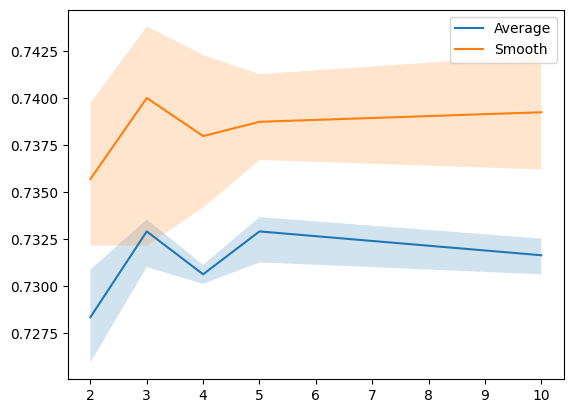

In [204]:
q = np.quantile(test_accs, [0.25, 0.5, 0.75], axis=1)
plt.plot(ensemble_sizes, q[1], label='Average')
plt.fill_between(ensemble_sizes, q[0], q[2], alpha=0.2)
q = np.quantile(test_accs_smooth, [0, 0.5, 1.0], axis=1)
plt.plot(ensemble_sizes, q[1], label='Smooth')
plt.fill_between(ensemble_sizes, q[0], q[2], alpha=0.2)
plt.legend()
plt.show()

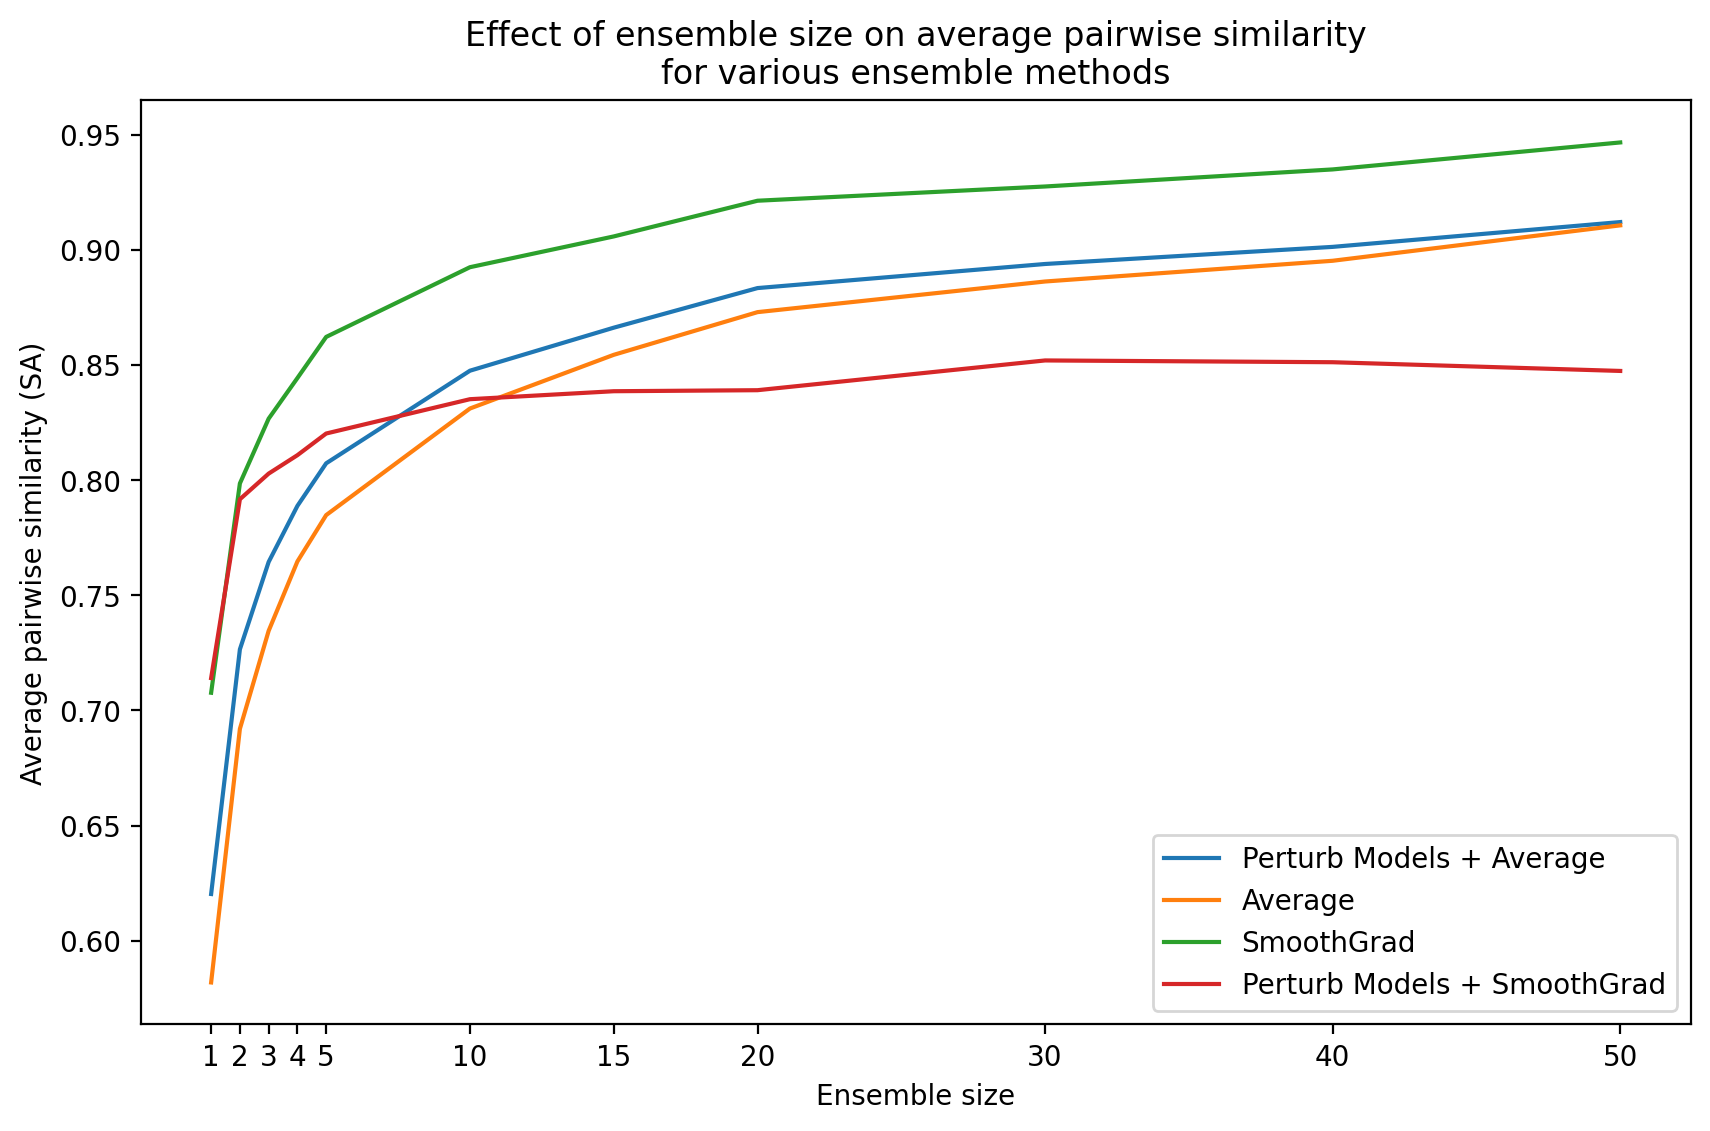

In [ ]:
plt.figure(figsize=(10, 6), dpi=200)
titles = ['Perturb Models + Average', 'Average', 'SmoothGrad', 'Perturb Models + SmoothGrad']
for i, metric in enumerate([SA_smooth, SA_avg, SA_sg, SA_sg_smooth]):
    # Error bars represent different inputs
    q = np.quantile(metric, [0.4, 0.5, 0.6], axis=1)
    plt.plot(ensemble_sizes, metric.mean(axis=1), label=titles[i])  # plot 50% quantile
    #plt.fill_between(ensemble_sizes, q[0], q[2], alpha=0.2)  # fill between 25% and 75% quantiles
plt.xlabel('Ensemble size')
plt.xticks(ensemble_sizes)
plt.ylabel('Average pairwise similarity (SA)')
plt.title('Effect of ensemble size on average pairwise similarity\nfor various ensemble methods')
plt.legend(loc='lower right')
plt.show()

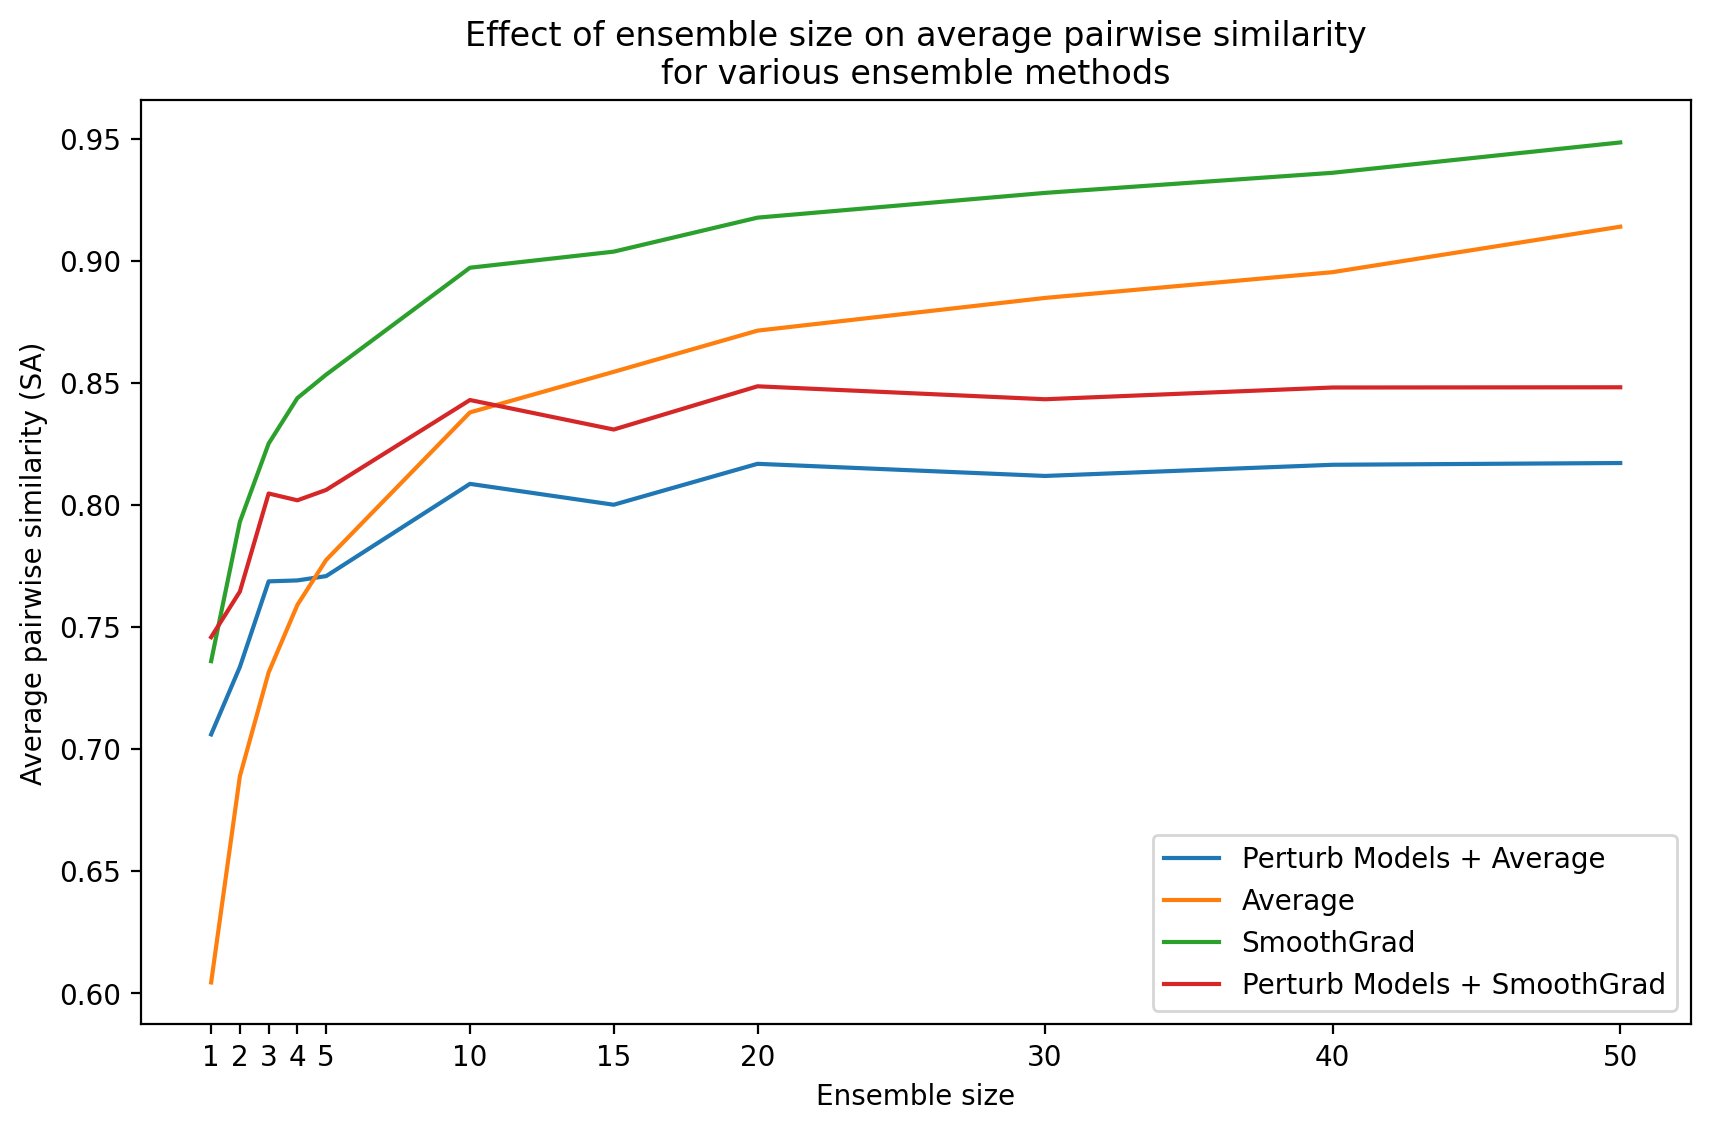

In [ ]:
plt.figure(figsize=(10, 6), dpi=200)
titles = ['Perturb Models + Average', 'Average', 'SmoothGrad', 'Perturb Models + SmoothGrad']
for i, metric in enumerate([SA_smooth, SA_avg, SA_sg, SA_sg_smooth]):
    # Error bars represent different inputs
    q = np.quantile(metric, [0.4, 0.5, 0.6], axis=1)
    plt.plot(ensemble_sizes, metric.mean(axis=1), label=titles[i])  # plot 50% quantile
    #plt.fill_between(ensemble_sizes, q[0], q[2], alpha=0.2)  # fill between 25% and 75% quantiles
plt.xlabel('Ensemble size')
plt.xticks(ensemble_sizes)
plt.ylabel('Average pairwise similarity (SA)')
plt.title('Effect of ensemble size on average pairwise similarity\nfor various ensemble methods')
plt.legend(loc='lower right')
plt.show()

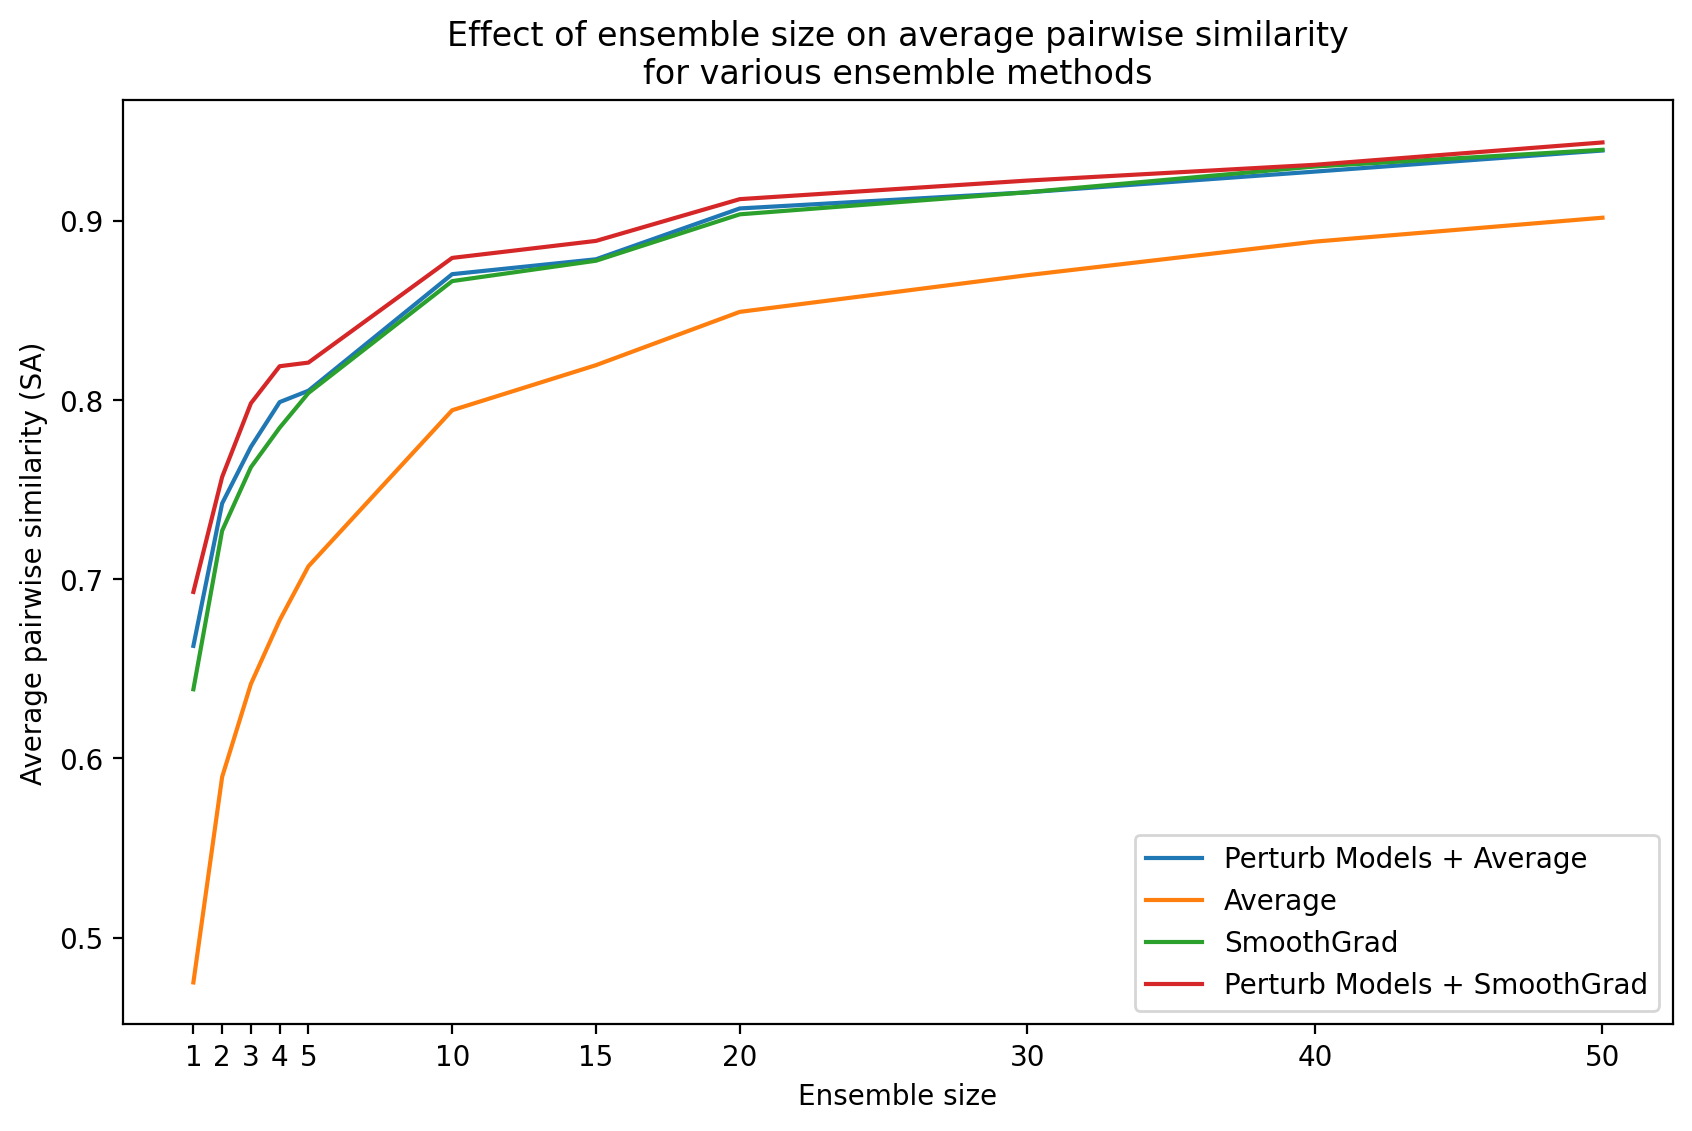

In [108]:
plt.figure(figsize=(10, 6), dpi=200)
titles = ['Perturb Models + Average', 'Average', 'SmoothGrad', 'Perturb Models + SmoothGrad']
for i, metric in enumerate([SA_smooth, SA_avg, SA_sg, SA_sg_smooth]):
    # Error bars represent different inputs
    q = np.quantile(metric, [0.4, 0.5, 0.6], axis=1)
    plt.plot(ensemble_sizes, metric.mean(axis=1), label=titles[i])  # plot 50% quantile
    #plt.fill_between(ensemble_sizes, q[0], q[2], alpha=0.2)  # fill between 25% and 75% quantiles
plt.xlabel('Ensemble size')
plt.xticks(ensemble_sizes)
plt.ylabel('Average pairwise similarity (SA)')
plt.title('Effect of ensemble size on average pairwise similarity\nfor various ensemble methods')
plt.legend(loc='lower right')
plt.show()

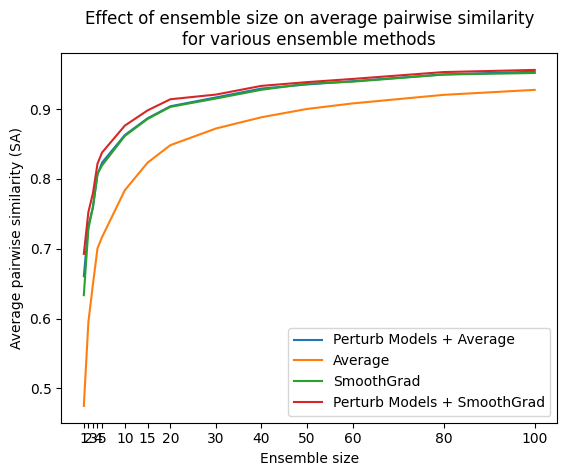

In [ ]:
titles = ['Perturb Models + Average', 'Average', 'SmoothGrad', 'Perturb Models + SmoothGrad',]
for i, metric in enumerate([SA_smooth, SA_avg, SA_sg, SA_sg_smooth]):
    # Error bars represent different inputs
    q = np.quantile(metric, [0.4, 0.5, 0.6], axis=1)
    plt.plot(ensemble_sizes, metric.mean(axis=1), label=titles[i])  # plot 50% quantile
    #plt.fill_between(ensemble_sizes, q[0], q[2], alpha=0.2)  # fill between 25% and 75% quantiles
plt.xlabel('Ensemble size')
plt.xticks(ensemble_sizes)
plt.ylabel('Average pairwise similarity (SA)')
plt.title('Effect of ensemble size on average pairwise similarity\nfor various ensemble methods')
plt.legend(loc='lower right')
plt.show()

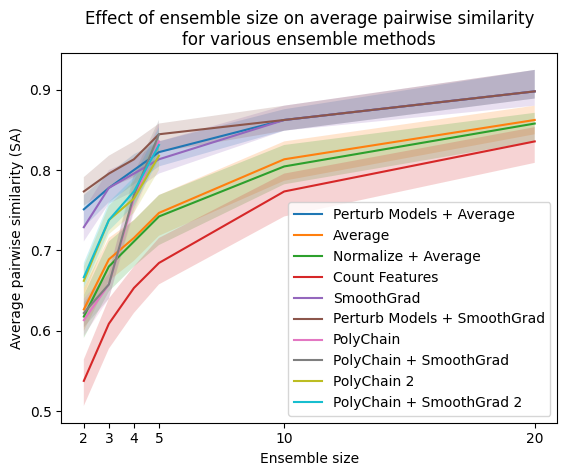

In [ ]:
titles = ['Perturb Models + Average', 'Average', 'Normalize + Average',
'Count Features', 'SmoothGrad', 'Perturb Models + SmoothGrad', 'PolyChain', 'PolyChain + SmoothGrad',
'PolyChain 2', 'PolyChain + SmoothGrad 2']
for i, metric in enumerate([SA_smooth, SA_avg, SA_norm_avg, SA, SA_sg, SA_sg_smooth, SA_mod, SA_sg_mod, SA_mod2, SA_sg_mod2]):
    # Error bars represent different inputs
    q = np.quantile(metric, [0.4, 0.5, 0.6], axis=1)
    if i > 5:
        plt.plot(ensemble_sizes[:4], q[1], label=titles[i])
        plt.fill_between(ensemble_sizes[:4], q[0], q[2], alpha=0.2)
    else:
        plt.plot(ensemble_sizes, q[1], label=titles[i])  # plot 50% quantile
        plt.fill_between(ensemble_sizes, q[0], q[2], alpha=0.2)  # fill between 25% and 75% quantiles
plt.xlabel('Ensemble size')
plt.xticks(ensemble_sizes)
plt.ylabel('Average pairwise similarity (SA)')
plt.title('Effect of ensemble size on average pairwise similarity\nfor various ensemble methods')
plt.legend(loc='lower right')
plt.show()

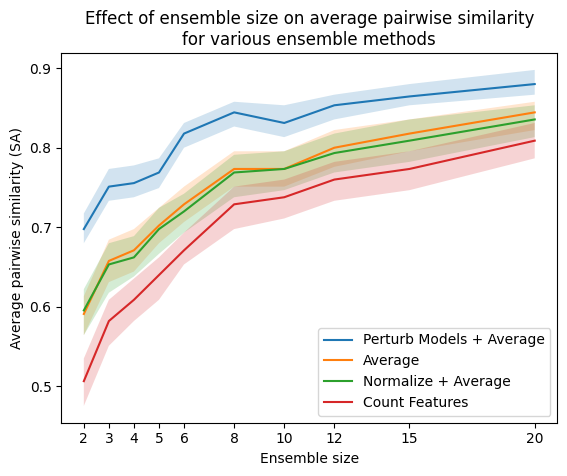

In [ ]:
titles = ['Perturb Models + Average', 'Average', 'Normalize + Average', 'Count Features']
for i, metric in enumerate([SA_smooth, SA_avg, SA_norm_avg, SA]):
    # Error bars represent different inputs
    q = np.quantile(metric, [0.4, 0.5, 0.6], axis=1)
    plt.plot(ensemble_sizes, q[1], label=titles[i])  # plot 50% quantile
    plt.fill_between(ensemble_sizes, q[0], q[2], alpha=0.2)  # fill between 25% and 75% quantiles
plt.xlabel('Ensemble size')
plt.xticks(ensemble_sizes)
plt.ylabel('Average pairwise similarity (SA)')
plt.title('Effect of ensemble size on average pairwise similarity\nfor various ensemble methods')
plt.legend()
plt.show()

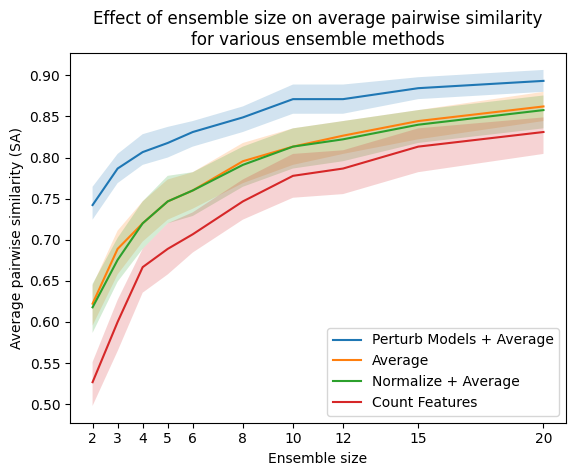

In [ ]:
titles = ['Perturb Models + Average', 'Average', 'Normalize + Average', 'Count Features']
for i, metric in enumerate([SA_smooth, SA_avg, SA_norm_avg, SA]):
    # Error bars represent different inputs
    q = np.quantile(metric, [0.4, 0.5, 0.6], axis=1)
    plt.plot(ensemble_sizes, q[1], label=titles[i])  # plot 50% quantile
    plt.fill_between(ensemble_sizes, q[0], q[2], alpha=0.2)  # fill between 25% and 75% quantiles
plt.xlabel('Ensemble size')
plt.xticks(ensemble_sizes)
plt.ylabel('Average pairwise similarity (SA)')
plt.title('Effect of ensemble size on average pairwise similarity\nfor various ensemble methods')
plt.legend()
plt.show()

In [95]:
n_singles = [10, 20, 30, 40, 50]
sa_single = np.zeros((len(n_singles), len(test_idx)))
for i, n_single in tqdm(enumerate(n_singles)):
    grads = np.array([np.load(f'{directory}/{random_source}_grads_{idx}.npy') for idx in range(n_single)])
    grads = grads[:, test_idx]
    tk_single, s_single = get_top_k(k, grads, return_sign=True)
    sa_single[i] = average_pairwise_score(tk_single, s_single, top_k_sa)

5it [00:17,  3.43s/it]


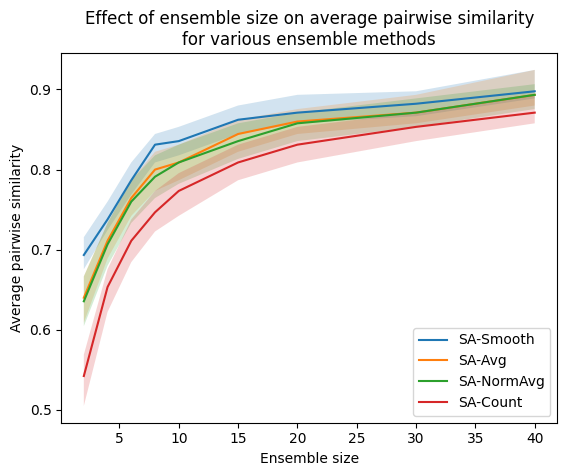

In [ ]:
titles = ['SA-Smooth', 'SA-Avg', 'SA-NormAvg', 'SA-Count']
for i, metric in enumerate([SA_smooth, SA_avg, SA_norm_avg, SA]):
    # Error bars represent different inputs
    q = np.quantile(metric, [0.4, 0.5, 0.6], axis=1)
    plt.plot(ensemble_sizes, q[1], label=titles[i])  # plot 50% quantile
    plt.fill_between(ensemble_sizes, q[0], q[2], alpha=0.2)  # fill between 25% and 75% quantiles
plt.xlabel('Ensemble size')
plt.ylabel('Average pairwise similarity')
plt.title('Effect of ensemble size on average pairwise similarity\nfor various ensemble methods')
plt.legend()
plt.show()

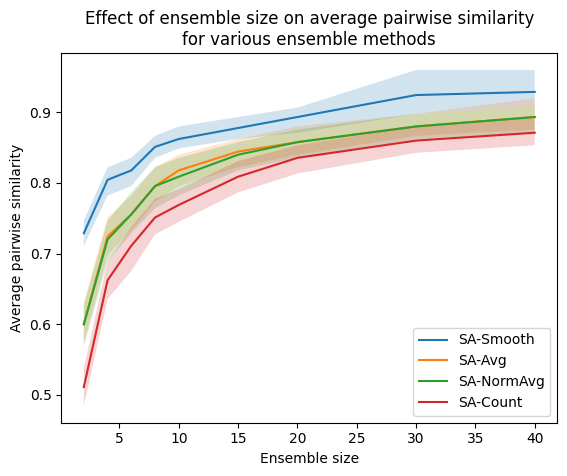

In [ ]:
titles = ['SA-Smooth', 'SA-Avg', 'SA-NormAvg', 'SA-Count']
for i, metric in enumerate([SA_smooth, SA_avg, SA_norm_avg, SA]):
    # Error bars represent different inputs
    q = np.quantile(metric, [0.4, 0.5, 0.6], axis=1)
    plt.plot(ensemble_sizes, q[1], label=titles[i])  # plot 50% quantile
    plt.fill_between(ensemble_sizes, q[0], q[2], alpha=0.2)  # fill between 25% and 75% quantiles
plt.xlabel('Ensemble size')
plt.ylabel('Average pairwise similarity')
plt.title('Effect of ensemble size on average pairwise similarity\nfor various ensemble methods')
plt.legend()
plt.show()

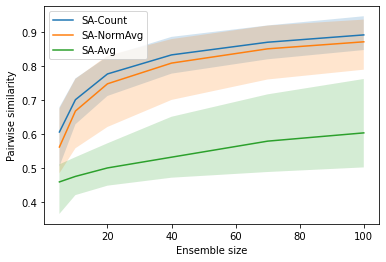

In [ ]:
titles = ['SA-Count', 'SA-NormAvg', 'SA-Avg']
for i, metric in enumerate([SA, SA_norm_avg, SA_avg]):
    # Error bars represent different inputs
    q = np.quantile(metric, [0.25, 0.5, 0.75], axis=1)
    plt.plot(ensemble_sizes, q[1], label=titles[i])  # plot 50% quantile
    plt.fill_between(ensemble_sizes, q[0], q[2], alpha=0.2)  # fill between 25% and 75% quantiles
plt.xlabel('Ensemble size')
plt.ylabel('Pairwise similarity')
plt.legend()
plt.show()

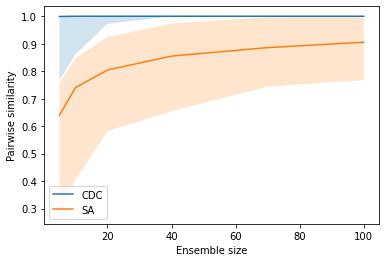

In [ ]:
titles = ['CDC', 'SA']
for i, metric in enumerate([CDC, SA]):
    # Error bars represent different inputs
    q = np.quantile(metric, [0.1, 0.5, 0.9], axis=1)
    plt.plot(ensemble_sizes, q[1], label=titles[i])  # plot 50% quantile
    plt.fill_between(ensemble_sizes, q[0], q[2], alpha=0.2)  # fill between 25% and 75% quantiles
plt.xlabel('Ensemble size')
plt.ylabel('Pairwise similarity')
plt.legend()
plt.show()

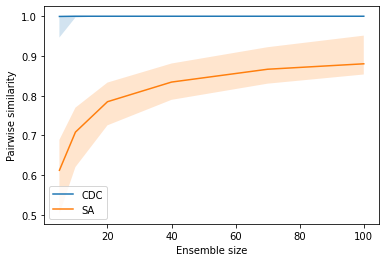

In [ ]:
titles = ['CDC', 'SA']
for i, metric in enumerate([CDC, SA]):
    # Error bars represent different inputs
    q = np.quantile(metric, [0.25, 0.5, 0.75], axis=1)
    plt.plot(ensemble_sizes, q[1], label=titles[i])  # plot 50% quantile
    plt.fill_between(ensemble_sizes, q[0], q[2], alpha=0.2)  # fill between 25% and 75% quantiles
plt.xlabel('Ensemble size')
plt.ylabel('Pairwise similarity')
plt.legend()
plt.show()

In [305]:
# 1 row, no. metrics columns
# metrics: consistency, SA, CDC, SSA
metrics = [consistencies, SA, CDC, SSA]

(6, 100)

### Misc Plots

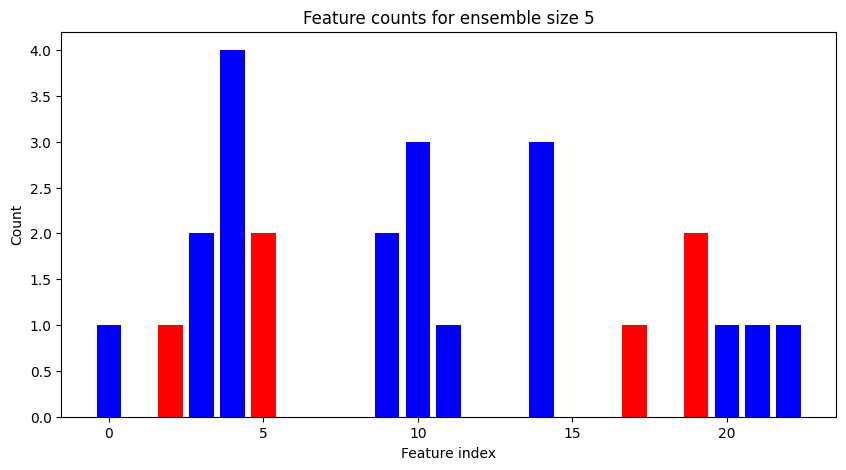

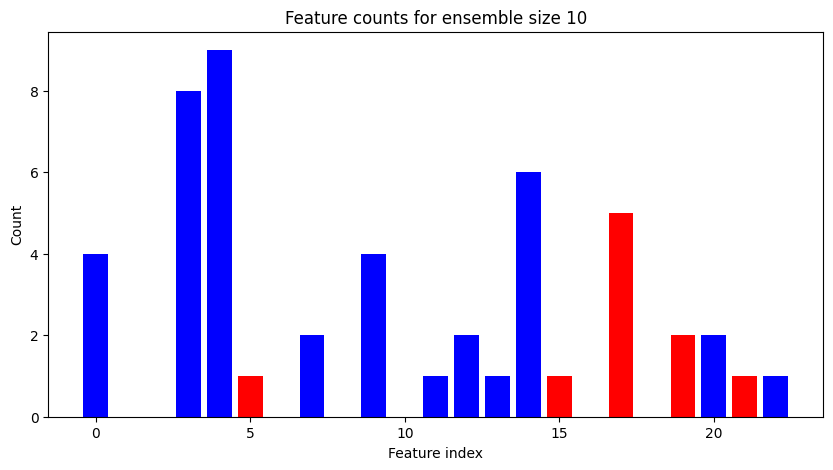

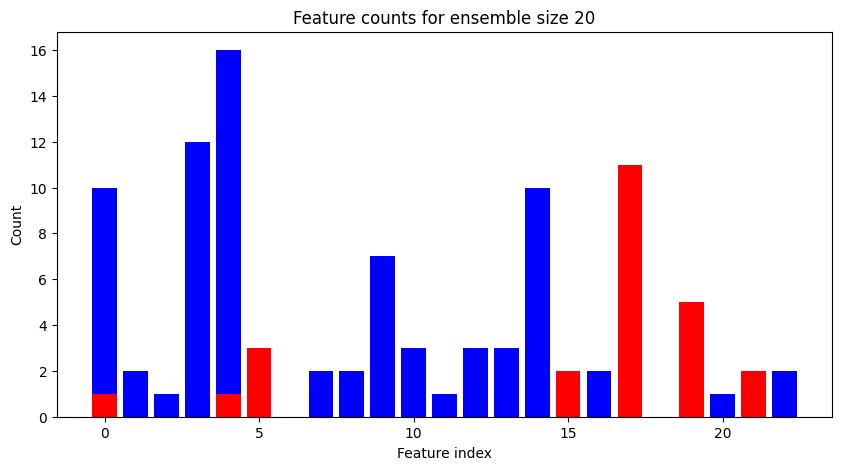

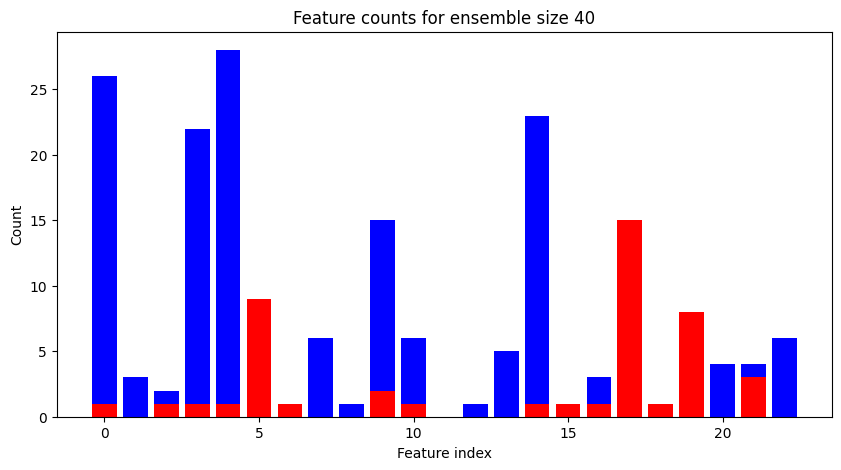

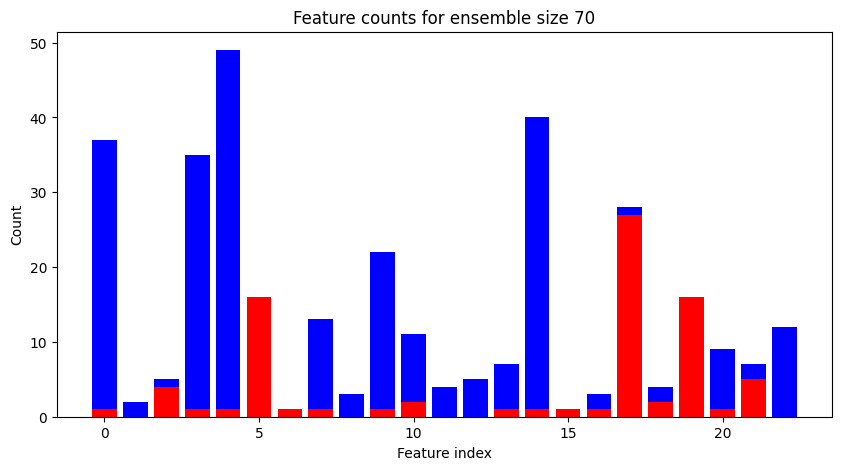

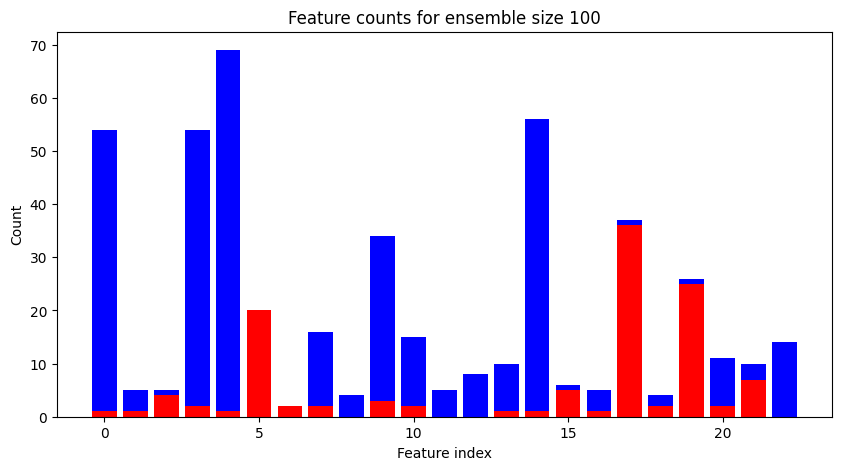

In [304]:
for i, ensemble_size in enumerate(ensemble_sizes):
    p, n = counts_pos[i][0,0], counts_neg[i][0,0]
    # Plot bar chart of feature counts, with positive and negative counts stacked
    plt.figure(figsize=(10, 5))
    plt.bar(range(n_features), p + n, color='blue')
    plt.bar(range(n_features), n, color='red')
    plt.title(f'Feature counts for ensemble size {ensemble_size}')
    plt.xlabel('Feature index')
    plt.ylabel('Count')
    plt.show()

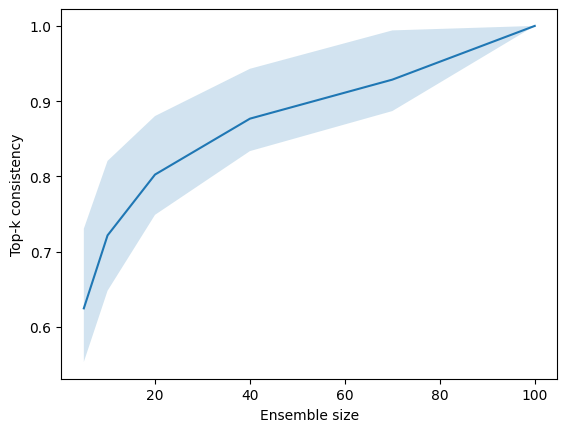

In [256]:
q = np.quantile(consistencies, [0.25, 0.5, 0.75], axis=1)
# Plot 50% quantile
plt.plot(ensemble_sizes, q[1], label='50% quantile')
# Fill between 25% and 75% quantiles
plt.fill_between(ensemble_sizes, q[0], q[2], alpha=0.2)
plt.xlabel('Ensemble size')
plt.ylabel('Top-k consistency')
plt.show()

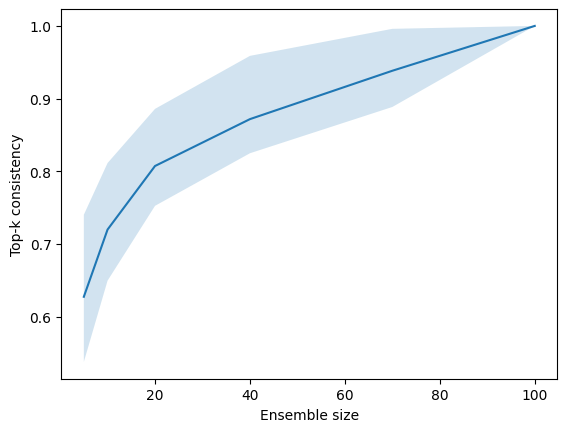

In [ ]:
q = np.quantile(consistencies, [0.25, 0.5, 0.75], axis=1)
# Plot 50% quantile
plt.plot(ensemble_sizes, q[1], label='50% quantile')
# Fill between 25% and 75% quantiles
plt.fill_between(ensemble_sizes, q[0], q[2], alpha=0.2)
plt.xlabel('Ensemble size')
plt.ylabel('Top-k consistency')
plt.show()

### How to load/visualize gradients

In [44]:
# Set ensemble size
size_ensemble = 10

In [45]:
# Randomly sample size_ensemble indices from 0 to n_models
indices = np.random.choice(n_models, size_ensemble, replace=False)
indices

array([ 5, 11, 15, 49, 41, 93,  7, 52, 96, 69])

In [46]:
# Load predictions and gradients for models with those indices
preds = np.array([np.load(f'{directory}/{random_source}_preds_{i}.npy') for i in indices])
grads = np.array([np.load(f'{directory}/{random_source}_grads_{i}.npy') for i in indices])

In [47]:
# grads has size (size_ensemble, n_inputs, n_features) for tabular data
n_inputs, n_features = grads.shape[1:]
n_inputs, n_features

(1975, 23)

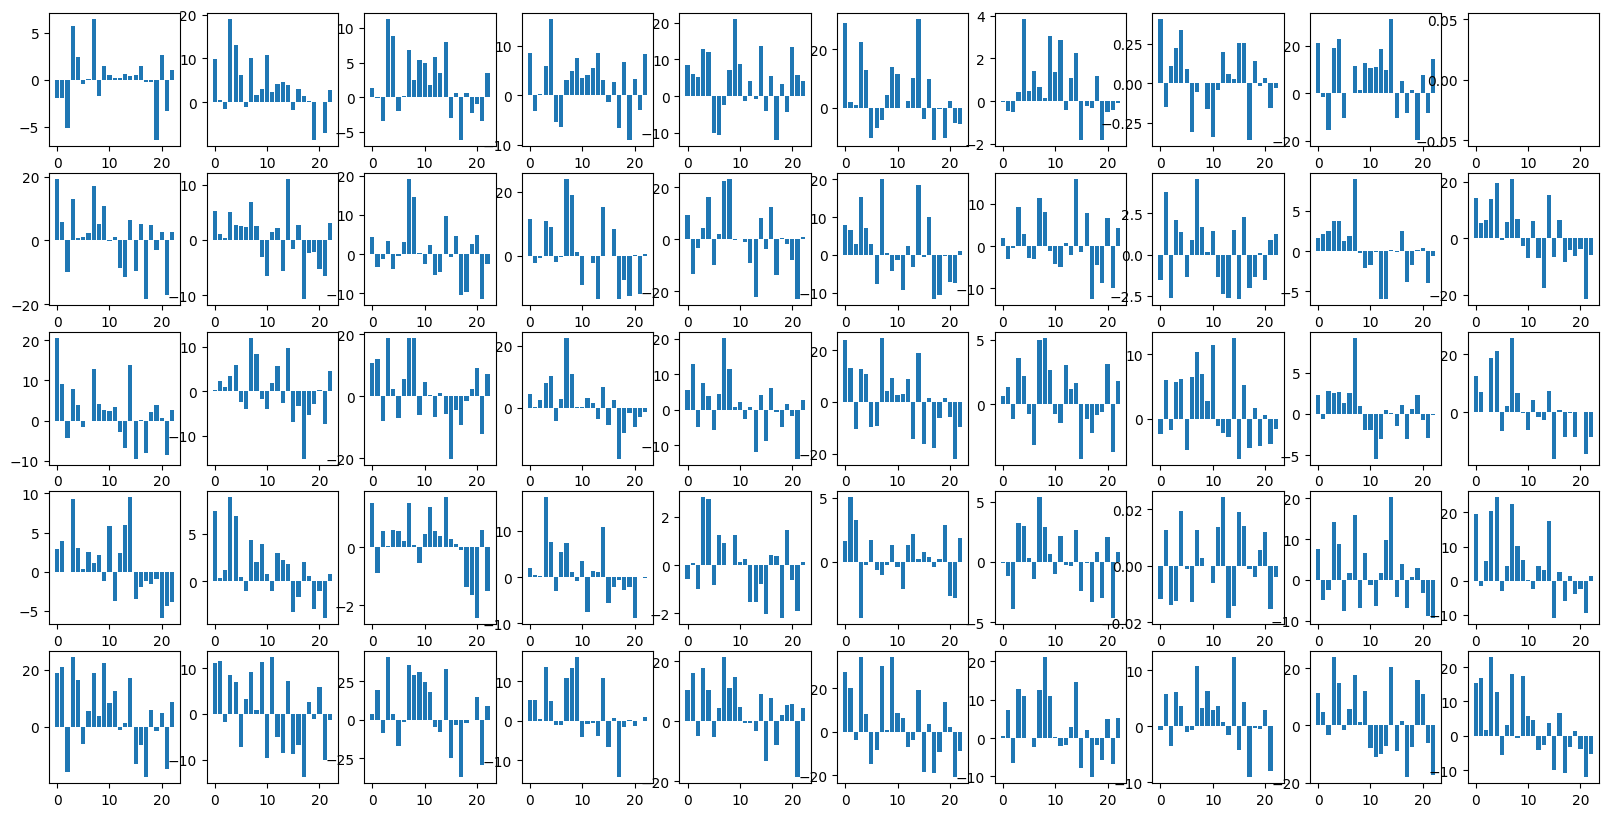

In [48]:
# Visualize gradients for each of the models in the ensemble for first 5 inputs
# Rows are inputs, columns are models
rows = 5
fig, axs = plt.subplots(rows, size_ensemble, figsize=(rows*4, size_ensemble), dpi=100)
for i in range(5):
    for j in range(size_ensemble):
        axs[i,j].bar(range(n_features), grads[j,i])
plt.show()

Okay so some gradients are zero... moreso if you do softmax gradient instead of logit gradient

Might just be a floating point error (could try float64 instead of float32 but will double the storage size)

softmax gradient and logit gradient should be the same (?), just softmax is magnitudes smaller

### Top k and comparisons

In [40]:
print("(no. models in ensemble, no. test inputs, no. features)")
print(grads.shape)

(no. models in ensemble, no. test inputs, no. features)
(10, 1975, 23)


In [41]:
from similarity_metrics import get_top_k

In [53]:
grads = np.array([np.load(f'{directory}/{random_source}_grads_{idx}.npy') for idx in indices])
grads.shape

(100, 1975, 23)

In [54]:
from tqdm import tqdm

In [155]:
from similarity_metrics import get_top_k

In [158]:
tk, s = get_top_k(k=5, X=grads, return_sign=True)

In [161]:
grads.shape

(100, 10, 23)

In [163]:
grads = np.array([np.load(f'{directory}/{random_source}_grads_{idx}.npy') for idx in model_idx])
grads = grads[:, test_idx]
grads.shape

(100, 10, 23)

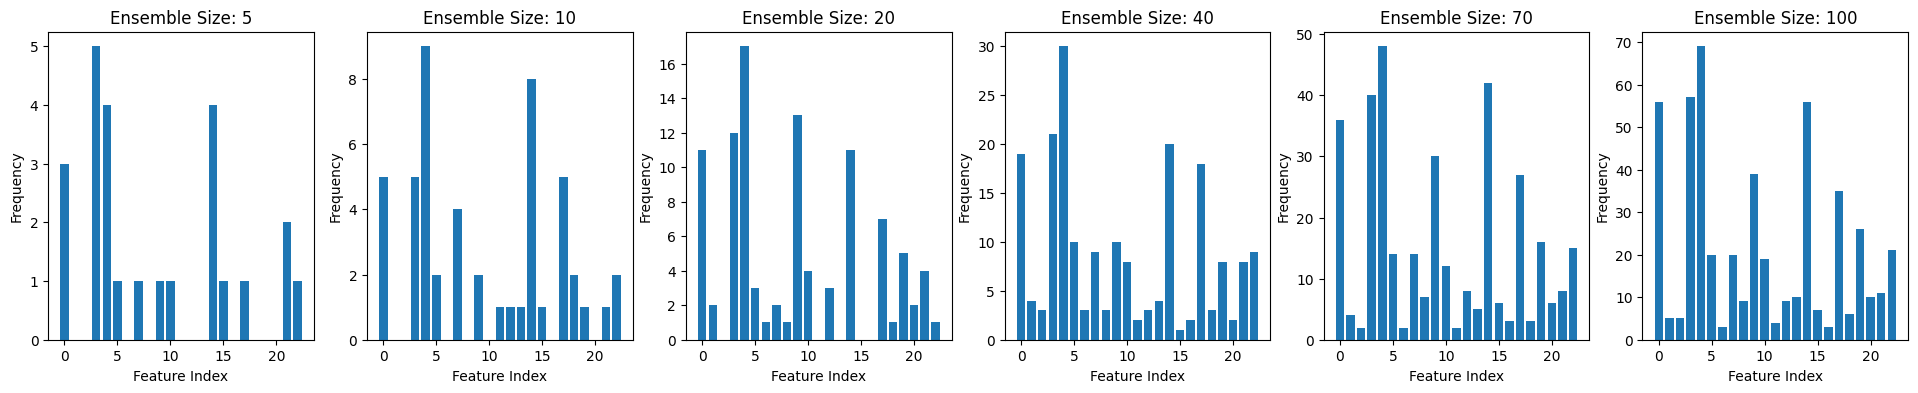

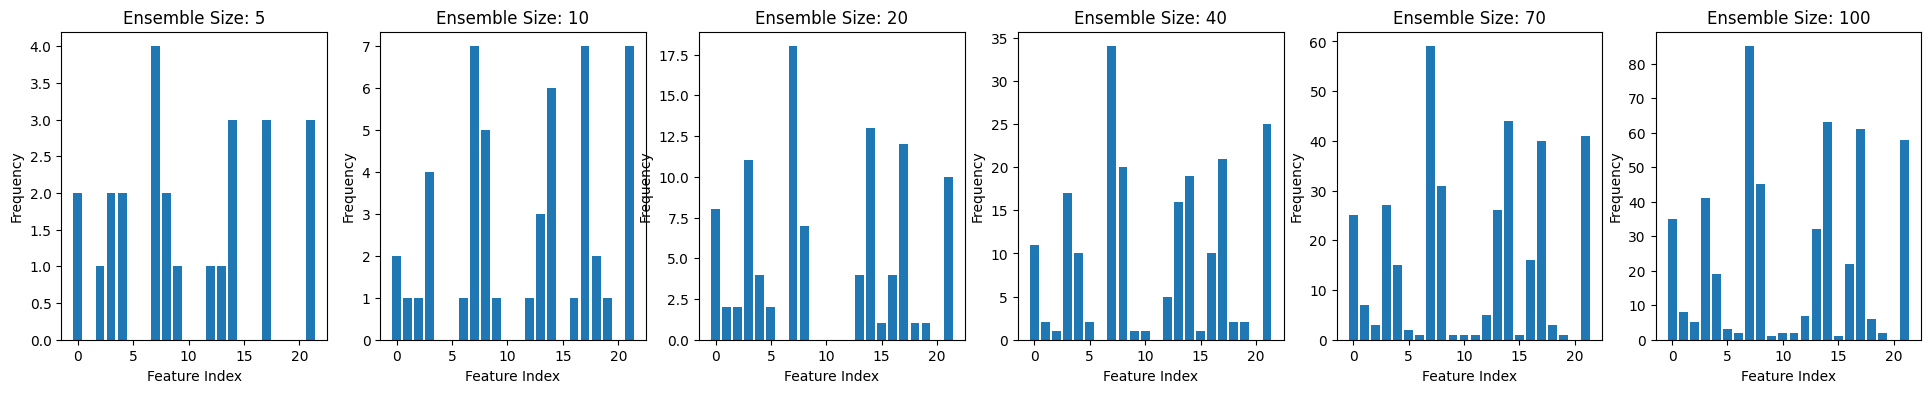

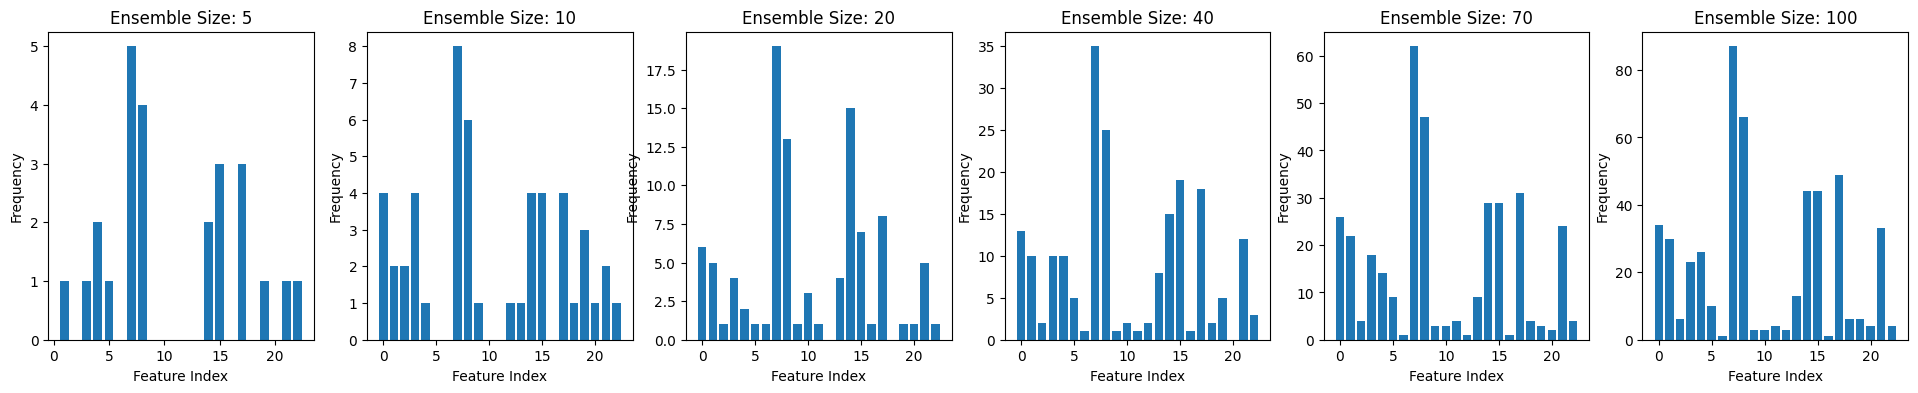

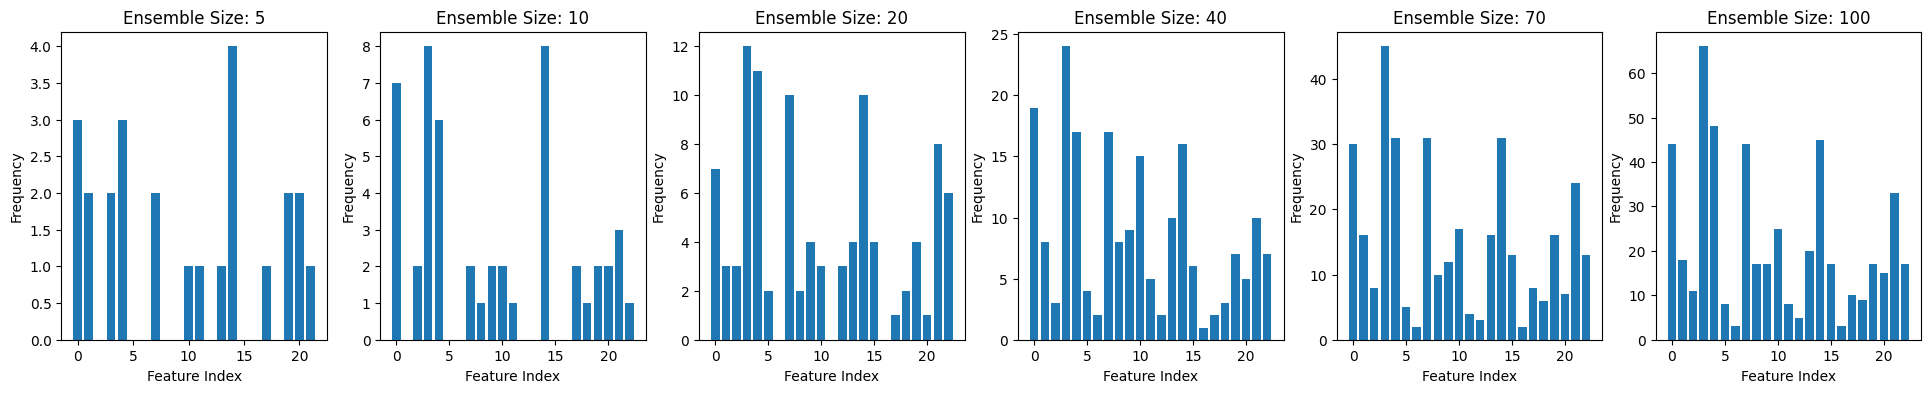

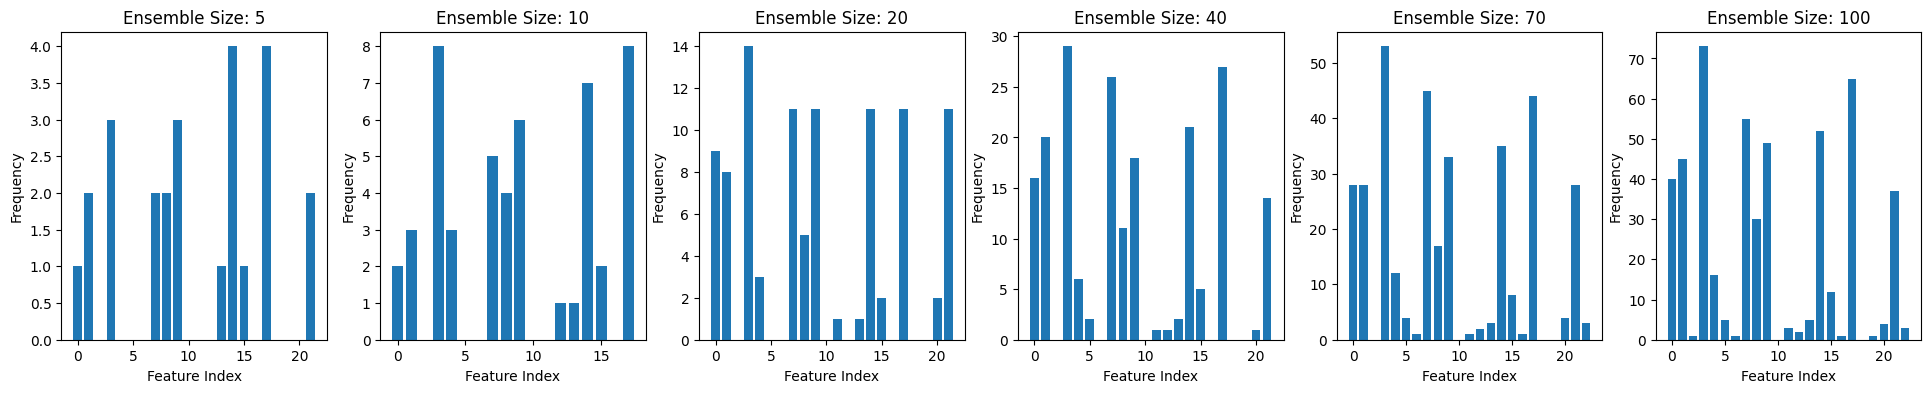

In [49]:
ensemble_sizes = [5, 10, 20, 40, 70, 100]
# Randomly sample size_ensemble indices from 0 to n_models for each ensemble size, load grads, and get top k grads
top5 = []
n_test = 5
counts = np.zeros((n_test, len(ensemble_sizes), n_features))
for i in range(n_test):
    fig, axs = plt.subplots(1, len(ensemble_sizes), figsize=(len(ensemble_sizes)*4, 4), dpi=100)
    for j, size_ensemble in enumerate(ensemble_sizes):
        indices = np.random.choice(n_models, size_ensemble, replace=False)  # should do this many times
        grads = np.array([np.load(f'{directory}/{random_source}_grads_{idx}.npy') for idx in indices])
        top5.append(np.array([get_top_k(grads[idx], k=5) for idx in range(size_ensemble)]))
        un, co = np.unique(top5[j][:, i].flatten(), return_counts=True)
        axs[j].bar(un, co)
        axs[j].set_xlabel('Feature Index')
        axs[j].set_ylabel('Frequency')
        axs[j].set_title(f'Ensemble Size: {size_ensemble}')
        counts[i, j, un] = co
    plt.show()

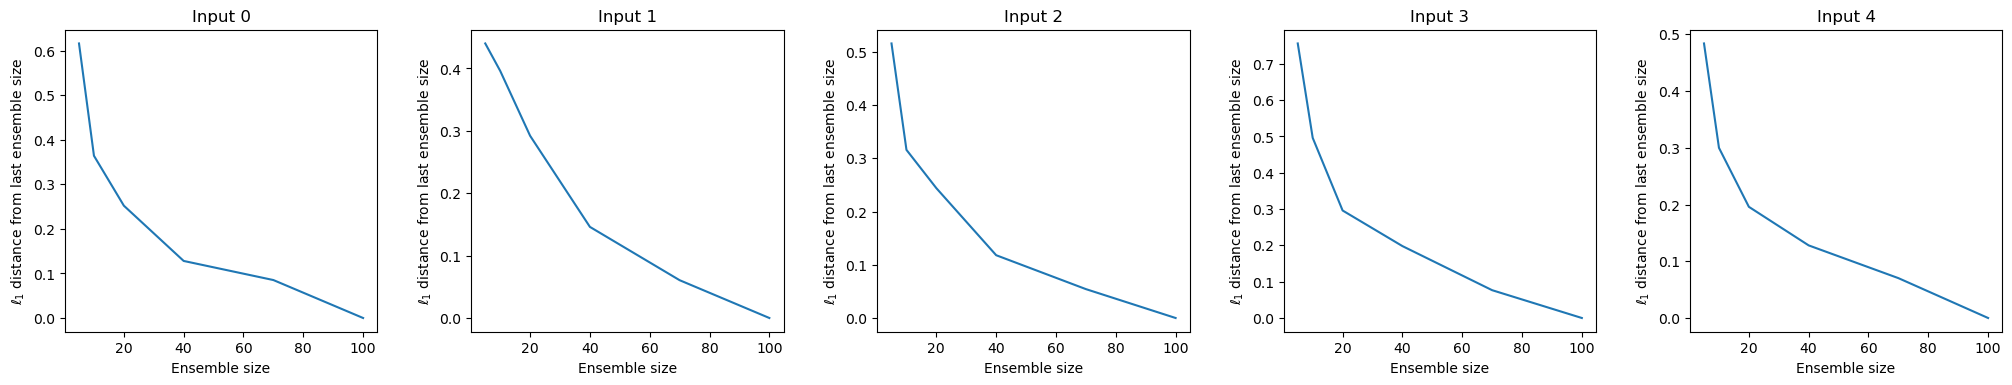

In [41]:
fig, axs = plt.subplots(1, n_test, figsize=(n_test*5, 4), dpi=100)
plt.subplots_adjust(wspace=0.3)
for i in range(n_test):
    counts_norm = counts[i]/np.sum(counts[i], axis=1)[:, None]
    axs[i].plot(ensemble_sizes, np.linalg.norm(counts_norm-counts_norm[-1], axis=1, ord=1))
    axs[i].set_xlabel('Ensemble size')
    axs[i].set_ylabel('$\ell_1$ distance from last ensemble size')
    axs[i].set_title(f'Input {i}')
plt.show()

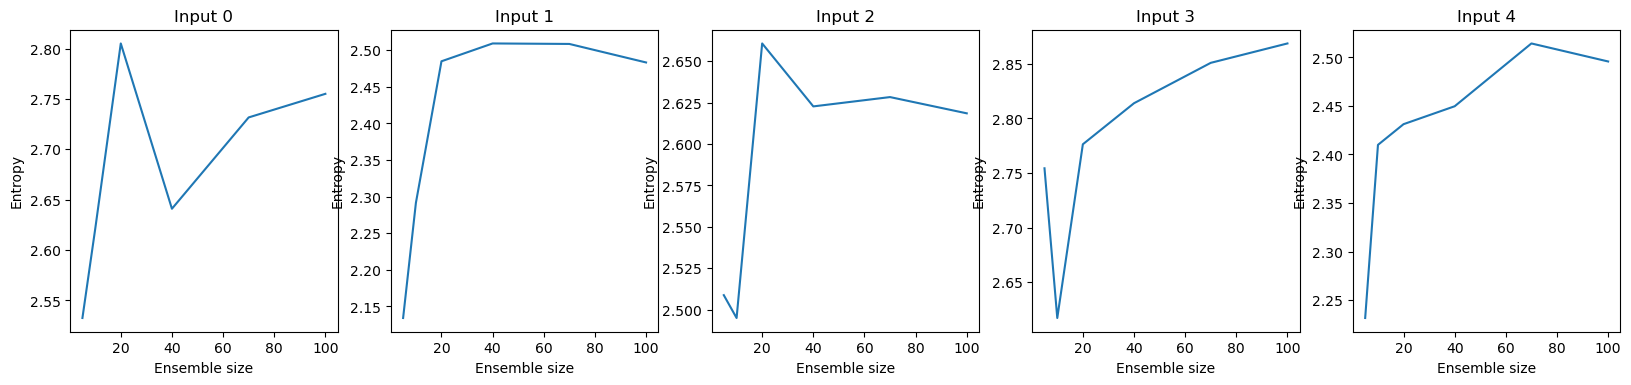

In [20]:
# Compute entropy of each feature distribution in counts
from scipy.stats import entropy
# Plot entropy of counts for each input
fig, axs = plt.subplots(1, n_test, figsize=(n_test*4, 4), dpi=100)
for i in range(n_test):
    full_counts_norm = counts[i, -1]/np.sum(counts[i, -1])
    counts[0]/np.sum(counts[0], axis=1)[:, None]
    axs[i].plot(ensemble_sizes, entropy(counts[i], axis=1))
    axs[i].set_xlabel('Ensemble size')
    axs[i].set_ylabel('Entropy')
    axs[i].set_title(f'Input {i}')
plt.show()

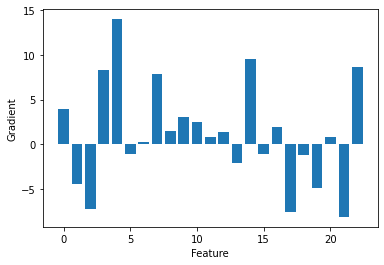

In [65]:
# Function for a single gradient plot
def plot_grad(grad, k=-1):
    # Optional top k gradients by absolute value
    if k > 0:
        grad = grad[np.argsort(np.abs(grad))[-k:]]
    plt.bar(range(grad.shape[0]), grad)
    plt.ylabel('Gradient')
    plt.xlabel('Feature')
    plt.show()

plot_grad(grads[0,0])